In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import dateutil
import pandas as pd
from scipy.optimize import differential_evolution, minimize
import pandas as pd
# source the nxcals python libs  #not needed as we only read already produced data files 
#from cern.nxcals.pyquery.builders import *

In [2]:
from cpymad.madx import Madx
import sys

# appending path to my acc physics librarymadx.call("/eos/user/e/elwaagaa/SWAN_projects/elias_technical_studentship/sps_sequences_and_twiss_ic/sps_short_injection_basic_{}.seq".format(optics))madx.call("/eos/user/e/elwaagaa/SWAN_projects/elias_technical_studentship/sps_sequences_and_twiss_ic/sps_short_injection_basic_{}.seq".format(optics))
sys.path.append('/eos/user/e/elwaagaa/Tech_student/Code')
from acc_phy_lib_elias import *

# Example notebook to check fitting of boxcar-shaped MKP peak

This notebook demonstrates the procedure to convert MKP voltage to actual kick, such that we can use the waveforms with MAD-X. The notebook reads waveform data generated previously with the NXCALS extracter. 

In [3]:
data = pd.read_csv('example_data/sps_lhcpilot_mkp1_data.csv')  #test such that saving worked fine
data = np.squeeze(np.array(data)) #remove dimensions 1 
x_time = np.arange(0, 2*len(data), 2, dtype=int)

In [4]:
plt.figure()
plt.plot(x_time, data)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### Test data for standard boxcar function

We want to fit a boxcar function to the MKP waveforms in the ideal case with a flat top. 

Here is some good input for fitting with a sharp gradient, where fitting boxcar-shaped functions can work out well. 
https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.optimize.differential_evolution.html
https://stackoverflow.com/questions/46624376/problems-fitting-to-boxcar-function-using-scipys-curvefit-in-python

Some comments on arguments and keyword arguments: https://www.geeksforgeeks.org/args-kwargs-python/

Define boxcar function that take x-array as input and returns boxcar values:

In [5]:
def box(x, *p):
    height, center, width = p
    return height*(center-width/2 < x)*(x < center+width/2)

In [6]:
x = np.linspace(-5,5, num=50000) #same number o
y = box(x, 1,0,2)

plt.figure()
plt.plot(x, y, '*')  #Height 1, width 2, center at 0
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [7]:
res = differential_evolution(lambda p: np.sum((box(x, *p) - y)**2), [[0, 2], [-5, 5], [0.1, 10]])  #bounds to parameter values
res

     fun: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 5145
     nit: 112
 success: True
       x: array([1.00000000e+00, 5.31190229e-05, 1.99998752e+00])

In [8]:
plt.figure()
plt.plot(x, y, '*')  #Height 1, width 2, center at 0
plt.step(x, box(x, *res.x), where='mid', label='diff-ev')
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### Fitting a boxcar function for the MKP kick

Apply the same cost functon but with the MKP WaveformData

In [9]:
res_mkp = differential_evolution(lambda p: np.sum((box(x_time, *p) - data)**2), [[0.0, 10.0], [0, 80000], [1000, 20000]], maxiter=10000)  #bounds to parameter values
res_mkp

     fun: 296.8250089790223
     jac: array([-5.68434192e-06,  0.00000000e+00,  0.00000000e+00])
 message: 'Optimization terminated successfully.'
    nfev: 1722
     nit: 37
 success: True
       x: array([3.50570664e+00, 6.96718214e+03, 4.14133053e+03])

In [10]:
plt.figure()
plt.plot(x_time, data, '*')
plt.step(x_time, box(x_time, *res_mkp.x), where='mid', label='diff-ev')
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### Adapt fit for flat top

As the MKP waveform is not a perfect boxcar function, the fit wants to minimize the residuals, often missing exactly where the flat top is. Create new data vector, where all the values less than 99% of the flat top are replaced by zeros.

In [11]:
data_flat_top = data
data_flat_top[data_flat_top<0.95*max(data_flat_top)] = 0

In [12]:
res_flat_top = differential_evolution(lambda p: np.sum((box(x_time, *p) - data_flat_top)**2), [[0.0, 10.0], [0, 80000], [1000, 20000]], maxiter=10000)  #bounds to parameter values
res_flat_top

     fun: 14.729510457606382
     jac: array([3.5527137e-07, 0.0000000e+00, 0.0000000e+00])
 message: 'Optimization terminated successfully.'
    nfev: 1812
     nit: 39
 success: True
       x: array([3.58619515e+00, 7.13799000e+03, 3.57856647e+03])

In [13]:
plt.figure()
plt.plot(x_time, data_flat_top, '*')
plt.step(x_time, box(x_time, *res_flat_top.x), where='mid', label='diff-ev')
plt.ylabel('Voltage [V]')
plt.xlabel('Time [ns]')
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

As we can see, the differential evolution quickly finds the best boxcar fit, from which the flat top can easily be deduced from the height of the boxcar. 

## Fit boxcar function to series of MKP waveform

There are presently 4 MKPs, and 2 sets of waveform data (A and B) for each. We read the data for each MKP of the selector **LHCPILOT**, saved from the notebook *Pandas-example-MKP-waveform*.

In [14]:
mkp_data = []
for i in range(16):
    mkp = np.genfromtxt('example_data/sps_lhcpilot_mkp{}_data.csv'.format(i+1), delimiter=' ')
    mkp_data.append(mkp)

#Add time vector
time = np.arange(0, 2*len(mkp), 2, dtype=int)
np.savetxt('example_data/sps_lhcpilot_time_data.txt',  time)

In [15]:
plt.figure()
for i in range(16):
    #if i == 2:
    plt.plot(time, mkp_data[i])
plt.ylabel('Voltage [V]')
plt.xlabel('Time [ns]')
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Remove data points where the values are less than 95% (not all flat tops are as stable this time) of the flat top are replaced by zeros and perform fit with differential evolution. Append filtered data, test results and boxcar heights (ultimately corresponding to the kick):

In [16]:
all_data_flat_top = []
flat_top_fits = []
flat_top_heights = []

for i in range(16):
    flat_top = np.copy(mkp_data[i])
    flat_top[flat_top<0.96*max(flat_top)] = 0
    all_data_flat_top.append(flat_top)
    fit = differential_evolution(lambda p: np.sum((box(time, *p) - flat_top)**2), [[0.0, 10.0], [0, 40000], [50, 30000]], maxiter=10000)  #bounds to parameter values
    flat_top_fits.append(fit)
    flat_top_heights.append(fit.x[0]) 

In [17]:
#Display the different heights
flat_top_heights = np.array(flat_top_heights)  #convert to numpy array
flat_top_heights

array([3.58665985, 3.64586473, 3.48851428, 3.72581167, 3.40129033,
       3.49921627, 3.53212187, 3.49988428, 3.34867467, 3.36486783,
       3.43223789, 3.40424259, 2.23312514, 2.28607097, 2.22843492,
       2.19648803])

In [18]:
#Plot grid with all fits 
fig1 = plt.figure(figsize=(15,12))
fig1.suptitle('MKP waveform fit - boxcar differential evolution',fontsize=20)
axes = []
count = 0

for i in range(16):
    if ((i+1) % 2) == 0:  #Check if even 
        string = 'B'
    else:
        count += 1 
        string = 'A'
    axes.append(fig1.add_subplot(4, 4, i+1))  # create an axes object in the figure
    axes[i].plot(time, all_data_flat_top[i], '*', label='{}{} data'.format(count, string))
    axes[i].set_xlim(4000, 10000)
    axes[i].step(time, box(time, *flat_top_fits[i].x), where='mid', label='Boxcar fit')
    plt.legend(loc="center right")
    axes[i].set_ylabel('Voltage [V]')
    axes[i].set_xlabel('Time [ns]')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [19]:
#Find max value for last two kickers, use these as reference time stamps
max_ind_1 = np.argmax(all_data_flat_top[14])  #for magnet module 15
max_ind_2 = np.argmax(all_data_flat_top[15])  #for magnet module 16
ref_time_stamp1 = time[max_ind_1]
ref_time_stamp2 = time[max_ind_2]
print("Timestamp_max: Magnet 7 = {} s, Magnet 8 = {} s".format(ref_time_stamp1, ref_time_stamp2))

Timestamp_max: Magnet 7 = 7014 s, Magnet 8 = 5828 s


## Translate the voltage to kick 

The different switches and how they are connected to the MKP magnet modules are displayed in the figure below (from Uythoven, 1999). 

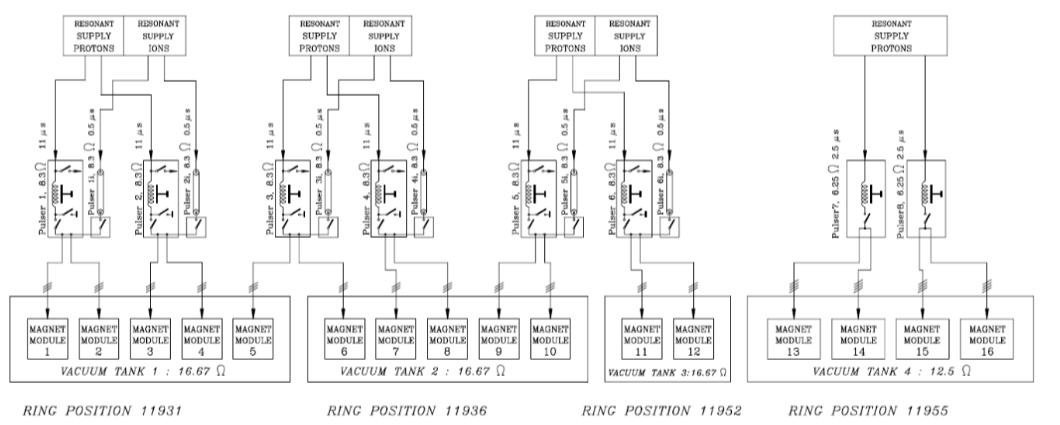

One such electrical switch corresponds to the process variable `MKP.BA1.IPOC.TMR1`, `MKP.BA1.IPOC.TMR2` and so on, where `A` and `B` indicate which one of the two magnet modules connected to this switcher. Looking at the graph, we see that 
* `MKP.BA1.IPOC.TMR1`, `MKP.BA1.IPOC.TMR2` and `MKP.BA1.IPOC.TMR3A` correspond to the first vacuum tank `mkpa.11931`
* `MKP.BA1.IPOC.TMR3B`, `MKP.BA1.IPOC.TMR4` and `MKP.BA1.IPOC.TMR5` correspond to the second vacuum tank `mkpa.11936`
* `MKP.BA1.IPOC.TMR6` correspond to the third vacuum tank `mkpc.11952` 
* `MKP.BA1.IPOC.TMR7` and `MKP.BA1.IPOC.TMR8` correspond to the fourth (last) vacuum tank `mkp.11955`

We assume that for each magnet module type (MKP-S-A, MKP-S-C or MKP-L) contain modules that contribute equally, as the voltage through all of them is identical. Thus, we simply load today's injection sequence for Q20 (LHC beam type, as we are in the `LHCPILOT` selector) and the kicks of the MKP magnets. Then, we just need to match the fitted flat tops of the corresponding voltage waveforms to the relevant kick. 

In [20]:
#Start MADX process and load the Q20 short injection sequence
with open('tempfile', 'w') as f:
    madx = Madx(stdout=f,stderr=f)
    
#Choose optics and load sequence and other values from MADX 
optics = 'q20'  #either q20, q26 or sftpro
twiss_reversed, twiss_forward_sps, survey_sps_forward, twiss_beta1, sige, ex, ey = load_seq(madx, optics)

RuntimeError: MAD-X has stopped working!

In [ ]:
#Extract the total kick for each MKP
mkp1_kick = madx.sequence['short_injection_basic'].elements['mkpa.11931'].kick
mkp2_kick = madx.sequence['short_injection_basic'].elements['mkpa.11936'].kick 
mkp3_kick = madx.sequence['short_injection_basic'].elements['mkpc.11952'].kick
mkp4_kick = madx.sequence['short_injection_basic'].elements['mkp.11955'].kick

#Find the fractional kick, i.e. how much actual kick each module contributes with 
mkp1_module_nr = 5
mkp2_module_nr = 5
mkp3_module_nr = 2
mkp4_module_nr = 4
module_nrs = [mkp1_module_nr, mkp2_module_nr, mkp3_module_nr, mkp4_module_nr]
mkp1_kick_fractional = mkp1_kick/mkp1_module_nr
mkp2_kick_fractional = mkp2_kick/mkp2_module_nr
mkp3_kick_fractional = mkp3_kick/mkp3_module_nr
mkp4_kick_fractional = mkp4_kick/mkp4_module_nr
fractional_kicks =[mkp1_kick_fractional, mkp2_kick_fractional, mkp3_kick_fractional, mkp4_kick_fractional]

#Concatenate these into a kick array, where each module is linked to a given kick - iterate over all fractional kicks
mkp_fractional_kicks = []
count = 0
for ele in module_nrs:
    for i in range(ele):
        mkp_fractional_kicks.append(fractional_kicks[count])
    count += 1
mkp_fractional_kicks = np.array(mkp_fractional_kicks) #convert to numpy array

#Now find the corresponding flattop heights to convert volts to kick 
conversion = np.divide(mkp_fractional_kicks, flat_top_heights )
mkp_data = np.array(mkp_data)
all_kick_data = []
for i in range(len(conversion)):
    kick_data = np.multiply(mkp_data[i], conversion[i])
    all_kick_data.append(kick_data)

In [ ]:
#Save data with kick waveforms for future use 
np.savetxt('example_data/sps_lhcpilot_kick_data.txt',  all_kick_data)

In [ ]:
#Test to load data to double-check
loaded_test_data = np.genfromtxt('/eos/user/e/elwaagaa/SWAN_projects/elias_technical_studentship/nxcals/mkp_waveforms/example_data/sps_lhcpilot_kick_data.txt')

In [ ]:
#Plot grid with all fits 
fig = plt.figure(figsize=(16,12))
fig.suptitle('MKP kick waveforms',fontsize=20)
axes = []
count = 0

for i in range(16):
    if ((i+1) % 2) == 0:  #Check if even 
        string = 'B'
    else:
        count += 1 
        string = 'A'
    axes.append(fig.add_subplot(4, 4, i+1))  # create an axes object in the figure
    axes[i].plot(time, all_kick_data[i], '*', label='{}{} data'.format(count, string))
    axes[i].set_xlim(0, 10000)
    plt.legend(loc="center left")
    axes[i].set_ylabel('Kick [rad]')
    axes[i].set_xlabel('Time [ns]')

Now we have all the kick waveform data through the conversion factors. 

Next step: make function $f = \Delta x(d \tau)$ that gives the final horizontal offset $\Delta x$ at the end of the sequence as a function of the time shift $d \tau$.

We actually have all the ingredients for this function:
* Converted voltage curves to kick. We know that the timestamp is at the middle of the flattop for the last MKPs.
* Depending on the given time shift $d \tau$, find the new kicks and update the madx globals according to these values
* Use same initial conditions `twiss_beta1` as before, perform a Twiss command with updated kicks.
* Calculate final horizontal offset $\Delta x$

In [ ]:
#Find the timestamp to as an example in the simulations - use a third into the flat top for MKP module 16 (meaning exactly at the midpoint - 1/6*width)
test_timestamp = 5630 # int(flat_top_fits[15].x[1] - 1/6*(flat_top_fits[15].x[2])) #round to nearest integer
dtau_1 = -500    #should still stay on the flat top 
dtau_2 = 2000    #should be enough to go out of the flat top

In [ ]:
#Function to give final horizontal shift dx depending on the general time shift delta_t for the MKP kickers 
#Provide delta_t, timestamp and the from-voltage-to-kick-converted MKP dataset, with given default initial conditions and MADX process as well
def MKP_time_shift(delta_t, converted_mkp_data_to_kick=all_kick_data, time_data=time, max_timestamp=test_timestamp, madx=madx, twiss_beta1=twiss_beta1):
    
    #Check at what time to evaluate the MKP kick
    t = max_timestamp + delta_t
    t_ind = np.argwhere(time_data==(t - (t % 2)))  #find closest even index corresponding to this time, as time goes in step of 2 ns
    new_kicks = []
    for i in range(len(converted_mkp_data_to_kick)):
        kick = converted_mkp_data_to_kick[i][t_ind]
        new_kicks.append(kick)
        #print("Kick {} at time {}!".format(kick, t))
    
    #Update the MKP kicks through the MADX globals
    madx.sequence['short_injection_basic'].elements['mkpa.11931'].kick = np.sum(new_kicks[:5])  #sum kicks of first 5 modules to give to the MADX element
    madx.sequence['short_injection_basic'].elements['mkpa.11936'].kick = np.sum(new_kicks[5:10])
    madx.sequence['short_injection_basic'].elements['mkpc.11952'].kick = np.sum(new_kicks[10:12])
    madx.sequence['short_injection_basic'].elements['mkp.11955'].kick = np.sum(new_kicks[12:16])
    
    #Perform a Twiss command 
    madx.use(sequence='short_injection_basic')
    twiss = madx.twiss(betx=twiss_beta1['betx'], alfx=-twiss_beta1['alfx'],
                            bety=twiss_beta1['bety'], alfy=-twiss_beta1['alfy'], 
                           dx=twiss_beta1['dx'], dpx=-twiss_beta1['dpx'],
                            dy = twiss_beta1['dy'], dpy=-twiss_beta1['dpy'],
                            x=twiss_beta1['x'], y=twiss_beta1['y'],
                            px=-twiss_beta1['px'], py=-twiss_beta1['py']).dframe()
                            
    delta_x = twiss['x'].loc['qf.12010']
    
    return delta_x

In [ ]:
MKP_time_shift(0, max_timestamp=5700)

In [ ]:
MKP_time_shift(dtau_1)

In [ ]:
MKP_time_shift(dtau_2)

But what is a reasonable `max_timestamp` to start with? Seems like a third into the flat top of the last MKP module gives a very low shift in horizontal positions. 

In [ ]:
#Test in what interval the reference timestamp should be
x = np.arange(5700, 6500, 50)
y = []
for ele in x:
    y.append(MKP_time_shift(0, max_timestamp=ele))

plt.figure()
plt.plot(x,y)

## Define function that takes vector input dtau

Now we create a similar function to the one above, but with dtau being a vector with 8 + 1 time shifts: one per switch (8) and one general time shift for all waveforms. Give oscillation amplitude of in the SPS as output, rather than only $dx$.

In [ ]:
#Give some tests values for the time shifts, but general and the individual 
delta_t = 200  #general time shift
delta_t_single = 50  #time shift for each waveform
dtau = np.full(8, delta_t_single)
dtau = np.append(dtau, delta_t)

In [ ]:
#Function to calculate the oscillations, but taking time vector with the time shift of all the individual switches and general time shift
def MKP_vector_time_shift(dtau, converted_mkp_data_to_kick=all_kick_data, time_data=time, max_timestamp=test_timestamp, madx=madx, twiss_beta1=twiss_beta1):
    
    #Check at what time to evaluate the MKP kick
    t = max_timestamp + dtau[-1]  #new general time stamp 
    t_inds = []
    for i in range(8):  #8 switches in total to iterate over 
        t_ind = np.argwhere(time_data==(t+dtau[i] - ((t+dtau[i]) % 2)))   #find closest even index corresponding to this time 
        t_inds.append(t_ind)
    
    #Iterate over the modules, check the time shift for each switch, and add the kicks
    new_kicks = []
    switch_count = 0
    for i in range(16):
        if (((i) % 2) == 0) and (i!=0):  #after every two steps, change electrical switch
            switch_count += 1  
        kick = converted_mkp_data_to_kick[i][t_inds[switch_count]]
        new_kicks.append(kick)
        #print(t_inds[switch_count])
        #print("Kick {} at time {}!".format(kick, t))
        
    #Update the MKP kicks through the MADX globals
    madx.sequence['short_injection_basic'].elements['mkpa.11931'].kick = np.sum(new_kicks[:5])  #sum kicks of first 5 modules to give to the MADX element
    madx.sequence['short_injection_basic'].elements['mkpa.11936'].kick = np.sum(new_kicks[5:10])
    madx.sequence['short_injection_basic'].elements['mkpc.11952'].kick = np.sum(new_kicks[10:12])
    madx.sequence['short_injection_basic'].elements['mkp.11955'].kick = np.sum(new_kicks[12:16])


    #Perform a Twiss command 
    madx.use(sequence='short_injection_basic')
    twiss = madx.twiss(betx=twiss_beta1['betx'], alfx=-twiss_beta1['alfx'],
                            bety=twiss_beta1['bety'], alfy=-twiss_beta1['alfy'], 
                           dx=twiss_beta1['dx'], dpx=-twiss_beta1['dpx'],
                            dy = twiss_beta1['dy'], dpy=-twiss_beta1['dpy'],
                            x=twiss_beta1['x'], y=twiss_beta1['y'],
                            px=-twiss_beta1['px'], py=-twiss_beta1['py']).dframe()
                            
    delta_x = twiss['x'].loc['qf.12010']
    
    return delta_x

In [ ]:
MKP_vector_time_shift(dtau)

In [ ]:
#Try to remoe the general time shift
dtau2 = np.copy(dtau)
dtau2[8] = 0
MKP_vector_time_shift(dtau2)

In [ ]:
#Make first switch be completely out 
dtau3 = np.copy(dtau)
dtau3[0] = -2000
MKP_vector_time_shift(dtau3)

It seems to be working! To double-check the general time shift and individual time shifts for the switches, activate the print statements in the function above and insert the commented time vector below:


In [ ]:
#dtau3 = [10, 10, 20, 10, 30, 40, 10, 90, delta_t]

## Define function with oscillation output

Define a similar function to the one above, but that outputs the square of the oscillation amplitude `x**2 + px**2`  in the SPS.

In [ ]:
#Function to calculate the square of the beam oscillations
def MKP_oscillations(dtau, optics, ax=None, converted_mkp_data_to_kick=all_kick_data, time_data=time, max_timestamp=test_timestamp, madx=madx, twiss_beta1=twiss_beta1):
    
    #Check at what time to evaluate the MKP kick
    t = max_timestamp + dtau[-1]  #new general time stamp 
    t_inds = []
    for i in range(8):  #8 switches in total to iterate over 
        t_ind = np.argwhere(time_data==(t+dtau[i] - ((t+dtau[i]) % 2)))   #find closest even index corresponding to this time 
        #t_ind = np.argwhere(time_data==(t+dtau[i]))  #find index corresponding to this time 
        t_inds.append(t_ind)
    
    #Iterate over the modules, check the time shift for each switch, and add the kicks
    new_kicks = []
    switch_count = 0
    for i in range(16):
        if (((i) % 2) == 0) and (i!=0):  #after every two steps, change electrical switch
            switch_count += 1  
        kick = converted_mkp_data_to_kick[i][t_inds[switch_count]]
        new_kicks.append(kick)
    
    #Define a vector with new MKP kicks
    mkp_kicks = np.empty(4)
    mkp_kicks[0] = np.sum(new_kicks[:5])
    mkp_kicks[1] = np.sum(new_kicks[5:10])
    mkp_kicks[2] = np.sum(new_kicks[10:12])
    mkp_kicks[3] = np.sum(new_kicks[12:16])
    
    oscillations = get_oscillations_injected_sps_beam_new_kicks(optics, madx, mkp_kicks)
    
    if ax is not None:
        plot_oscillations_injected_sps_beam_new_kicks(mkp_kicks, ax, optics, sige, ex, ey, madx)
    
    return oscillations 

In [ ]:
MKP_oscillations(dtau, optics)

In [ ]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(1, 1, 1)
MKP_oscillations(dtau2, optics, ax)

In [ ]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(1, 1, 1)
MKP_oscillations(dtau3, optics, ax)

## Define function with oscillation output, also for circulating beam

Create function similar to the one above, but also check the oscillations for the circulating beam given a certain time spacing `dtc` to the batch of the circulating beam, coming right after.

In [ ]:
#Function to calculate oscillations of the circulating beam (subscript c) as well 
def MKP_and_circulating_oscillations(dtau, dtc, optics, converted_mkp_data_to_kick=all_kick_data, time_data=time, max_timestamp=test_timestamp, madx=madx, twiss_beta1=twiss_beta1):
    
    #Check at what time to evaluate the MKP kick for the injected beam, and for the circulating beam
    t = max_timestamp + dtau[-1]  #new general time stamp 
    tc = max_timestamp + dtau[-1] - dtc  #new general time stamp for circulating beam
    t_inds = []
    tc_inds = []
    for i in range(8):  #8 switches in total to iterate over 
        #t_ind = np.argwhere(time_data==(t+dtau[i]))  
        #tc_ind = np.argwhere(time_data==(tc+dtau[i])) 
        t_ind = np.argwhere(time_data==(t+dtau[i] - ((t+dtau[i]) % 2)))  #find closest even index corresponding to this time 
        tc_ind = np.argwhere(time_data==(tc+dtau[i] - ((tc+dtau[i]) % 2)))  
        t_inds.append(t_ind)
        tc_inds.append(tc_ind)
    
    #Iterate over the modules, check the time shift for each switch, and add the kicks for the injected and circulating beam
    new_kicks = []
    new_kicks_c = []
    switch_count = 0
    for i in range(16):
        if (((i) % 2) == 0) and (i!=0):  #after every two steps, change electrical switch
            switch_count += 1  
        kick = converted_mkp_data_to_kick[i][t_inds[switch_count]]
        kick_c = converted_mkp_data_to_kick[i][tc_inds[switch_count]]
        new_kicks.append(kick)
        new_kicks_c.append(kick_c)
    
    #Define a vector with new MKP kicks, for the injected and circulating beam
    mkp_kicks = np.empty(4)
    mkp_kicks[0] = np.sum(new_kicks[:5])
    mkp_kicks[1] = np.sum(new_kicks[5:10])
    mkp_kicks[2] = np.sum(new_kicks[10:12])
    mkp_kicks[3] = np.sum(new_kicks[12:16])
    mkp_kicks_c = np.empty(4)
    mkp_kicks_c[0] = np.sum(new_kicks_c[:5])
    mkp_kicks_c[1] = np.sum(new_kicks_c[5:10])
    mkp_kicks_c[2] = np.sum(new_kicks_c[10:12])
    mkp_kicks_c[3] = np.sum(new_kicks_c[12:16])
    #print(mkp_kicks_c)
    
    oscillations = get_oscillations_injected_sps_beam_new_kicks(optics, madx, mkp_kicks)
    oscillations_c = get_oscillations_circulating_sps_beam_new_kicks(optics, madx, mkp_kicks_c)

    return oscillations, mkp_kicks, oscillations_c, mkp_kicks_c

Perform some tests to see if the circulating beam is really affected by the individual MKP kicks, depending on the timestamp.

In [ ]:
dtc = 1100
dtc2 = 1200
oscillations, mkp_kicks, oscillations_c, mkp_kicks_c = MKP_and_circulating_oscillations(dtau, dtc, optics)
oscillations2, mkp_kicks2, oscillations_c2, mkp_kicks_c2 = MKP_and_circulating_oscillations(dtau, dtc2, optics)

In [ ]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(1, 1, 1)
twiss_injected = plot_oscillations_injected_sps_beam_new_kicks(mkp_kicks, ax, optics, sige, ex, ey, madx)
twiss_c = plot_oscillations_circulating_sps_beam_new_kicks(mkp_kicks_c, ax, optics, sige, ex, ey, madx, twiss_injected=twiss_injected)
plt.ylim(-0.1, 0.1)
plt.xlim(30, 550)

In [ ]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(1, 1, 1)
twiss_injected2 = plot_oscillations_injected_sps_beam_new_kicks(mkp_kicks2, ax, optics, sige, ex, ey, madx)
twiss_c2 = plot_oscillations_circulating_sps_beam_new_kicks(mkp_kicks_c2, ax, optics, sige, ex, ey, madx, twiss_injected=twiss_injected2)
plt.ylim(-0.1, 0.1)
plt.xlim(30, 550)

In [ ]:
#Also try with dtau3, meaning a larger general time shift 
oscillations3, mkp_kicks3, oscillations_c3, mkp_kicks_c3 = MKP_and_circulating_oscillations(dtau3, dtc2, optics)

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(1, 1, 1)
twiss_injected2 = plot_oscillations_injected_sps_beam_new_kicks(mkp_kicks3, ax, optics, sige, ex, ey, madx)
twiss_c2 = plot_oscillations_circulating_sps_beam_new_kicks(mkp_kicks_c3, ax, optics, sige, ex, ey, madx, twiss_injected=twiss_injected2)
plt.ylim(-0.1, 0.1)
plt.xlim(30, 550)

#Tried to add aperture, but later elements in the SPS do not seem to be included in these database files.
"""madx.call("/eos/user/e/elwaagaa/documents/waagaard_tech_studentship/data/sps_aperture_data/aperturedb_1.dbx")
madx.call("/eos/user/e/elwaagaa/documents/waagaard_tech_studentship/data/sps_aperture_data/aperturedb_2.dbx")
madx.call("/eos/user/e/elwaagaa/documents/waagaard_tech_studentship/data/sps_aperture_data/aperturedb_3.dbx")
twiss = twiss_c2.iloc[1:-2 , :]
#Get neat aperture for SPS, and select index for the desired apertures
new_pos_x, aper_neat_x = get_apertures_real(twiss_c2)
ind = (new_pos_x > 0)   #twiss.loc['msi.118550'].s
plot_aper_real(new_pos_x[ind], aper_neat_x[ind], ax)#"""

It seems like `dtc` around 1100 ns is like a breaking point --> at `dtc` of around 1200 ns between the injected batch and the circulating batch, the circulating beam is not affected by the kicker. This depend on the reference time of the MKP waveform - if the reference timestamp is 6000 ns and the waveform flat tops start at around 5000 ns, then a larger interval means that the circulating beam kick is entirely outside.

## Optimisation tests of function

With `scipy`, we try to optimise the `dtau` vector to find the best possible timing.

In [ ]:
#Function to calculate oscillations of the circulating beam (subscript c) as well 
def MKP_and_circulating_oscillations_optimise(dtau, dtc=dtc, optics=optics, converted_mkp_data_to_kick=all_kick_data, time_data=time, max_timestamp=test_timestamp, madx=madx, twiss_beta1=twiss_beta1):
    
    #Check at what time to evaluate the MKP kick for the injected beam, and for the circulating beam
    t = dtau[-1]  #new general time stamp 
    tc = dtau[-1] - dtc  #new general time stamp for circulating beam
    t_inds = []
    tc_inds = []
    for i in range(8):  #8 switches in total to iterate over 
        #t_ind = np.argwhere(time_data==(t+dtau[i]))  
        #tc_ind = np.argwhere(time_data==(tc+dtau[i])) 
        t_ind = np.argwhere(time_data==(t+dtau[i] - ((t+dtau[i]) % 2)))  #find closest even index corresponding to this time 
        tc_ind = np.argwhere(time_data==(tc+dtau[i] - ((tc+dtau[i]) % 2)))  
        t_inds.append(t_ind)
        tc_inds.append(tc_ind)
    
    #Iterate over the modules, check the time shift for each switch, and add the kicks for the injected and circulating beam
    new_kicks = []
    new_kicks_c = []
    switch_count = 0
    for i in range(16):
        if (((i) % 2) == 0) and (i!=0):  #after every two steps, change electrical switch
            switch_count += 1  
        kick = converted_mkp_data_to_kick[i][t_inds[switch_count]]
        kick_c = converted_mkp_data_to_kick[i][tc_inds[switch_count]]
        new_kicks.append(kick)
        new_kicks_c.append(kick_c)
    
    #Define a vector with new MKP kicks, for the injected and circulating beam
    mkp_kicks = np.empty(4)
    mkp_kicks[0] = np.sum(new_kicks[:5])
    mkp_kicks[1] = np.sum(new_kicks[5:10])
    mkp_kicks[2] = np.sum(new_kicks[10:12])
    mkp_kicks[3] = np.sum(new_kicks[12:16])
    mkp_kicks_c = np.empty(4)
    mkp_kicks_c[0] = np.sum(new_kicks_c[:5])
    mkp_kicks_c[1] = np.sum(new_kicks_c[5:10])
    mkp_kicks_c[2] = np.sum(new_kicks_c[10:12])
    mkp_kicks_c[3] = np.sum(new_kicks_c[12:16])
    #print(mkp_kicks_c)
    
    oscillations = get_oscillations_injected_sps_beam_new_kicks(optics, madx, mkp_kicks)
    oscillations_c = get_oscillations_circulating_sps_beam_new_kicks(optics, madx, mkp_kicks_c)

    obj_func = oscillations + oscillations_c
    
    return obj_func

In [ ]:
MKP_and_circulating_oscillations_optimise(dtau)

In [ ]:
#Carry out the optimisation, initialise some parameters
#solver = 'Nelder-Mead'
#dtau0 = dtau
#dtau0[-1] = 5600
#bounds = ((0, 50), (0, 50), (0, 50), (0, 50), (0, 50), (0, 50), (0, 50), (0, 50), (5200, 5700)) 
#results = minimize(MKP_and_circulating_oscillations_optimise, dtau0, method=solver, options={'adaptive': True})
#print(results)